<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = True
SEGMENTATION = True
CLAHE = False

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

  !kaggle datasets download -d "tschandl/ham10000-lesion-segmentations"

  !unzip -o ham10000-lesion-segmentations.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029321_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029322_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029323_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029324_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029325_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029326_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029327_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029328_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029329_segmentation.png  
  in

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setmasks__(self,masks):
      self.masks = masks

  def __getmask__(self,i):
      return self.masks[i]

  def __lenmasks__(self):
    return len(self.masks)

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if SEGMENTATION:
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        _, mask_binaria = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        image = cv2.bitwise_and(image, image, mask=mask_binaria)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)

  mask_files = sorted(glob('/content/sample_data/HAM10000_segmentations_lesion_tschandl/*'))

  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  mask_path_dict = {os.path.splitext(os.path.basename(x))[0].replace('_segmentation', ''): x for x in mask_files}

  #print(mask_path_dict)

  #{'ISIC_0024306_segmentation': '/content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png'

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['mask_path'] = metadates['image_id'].map(mask_path_dict.get)

  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)

  if SEGMENTATION:

    train_data.__setmasks__(X_train['mask_path'].to_numpy())
    test_data.__setmasks__(X_test['mask_path'].to_numpy())
    validation_data.__setmasks__(X_val['mask_path'].to_numpy())

  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [6]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

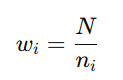

In [7]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [8]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [9]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [10]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [11]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [12]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [13]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [14]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)
    clean_img = torch.tensor(clean_img)

    imatge,label = train_data.__getitem__(i)

    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'resnet152multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    # transforms.RandomGrayscale(p = 0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

CLAHE = True
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "CLAHE": CLAHE,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 212MB/s]


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': True}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.4146536932998444
Accuracy train epoch: 1  train_acc: 0.5053875407461065
F1 train epoch: 1  train_f1: 0.5600454525408293
Recall train epoch: 1  train_recall: 0.5053875407461065


Pèrdua validació epoch: 1  val_loss: 1.0173142859712243
Accuracy val epoch: 1  val_acc: 0.6412109375
F1 val epoch: 1  val_f1: 0.6849189798569
Recall val epoch: 1  val_recall: 0.6412109375
Recall val epoch: 1  val_precision: 0.8128121553723288


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.9150236045934289
Accuracy train epoch: 2  train_acc: 0.6768041470481709
F1 train epoch: 2  train_f1: 0.7233607817317811
Recall train epoch: 2  train_recall: 0.6768041470481709


Pèrdua validació epoch: 2  val_loss: 0.8022038768976927
Accuracy val epoch: 2  val_acc: 0.696484375
F1 val epoch: 2  val_f1: 0.7321083086697033
Recall val epoch: 2  val_recall: 0.696484375
Recall val epoch: 2  val_precision: 0.8243157579463705


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.765095629658832
Accuracy train epoch: 3  train_acc: 0.7045907279971024
F1 train epoch: 3  train_f1: 0.7472072328063876
Recall train epoch: 3  train_recall: 0.7045907279971024


Pèrdua validació epoch: 3  val_loss: 0.7916056970134377
Accuracy val epoch: 3  val_acc: 0.701171875
F1 val epoch: 3  val_f1: 0.7383710213294159
Recall val epoch: 3  val_recall: 0.701171875
Recall val epoch: 3  val_precision: 0.8430068656546427


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.6538796251513569
Accuracy train epoch: 4  train_acc: 0.7349465773270554
F1 train epoch: 4  train_f1: 0.7728918783892359
Recall train epoch: 4  train_recall: 0.7349465773270554


Pèrdua validació epoch: 4  val_loss: 0.6675210250541568
Accuracy val epoch: 4  val_acc: 0.7431640625
F1 val epoch: 4  val_f1: 0.7732478844416145
Recall val epoch: 4  val_recall: 0.7431640625
Recall val epoch: 4  val_precision: 0.8595593815847586


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.5764195086709056
Accuracy train epoch: 5  train_acc: 0.7451896957624049
F1 train epoch: 5  train_f1: 0.7818212336300112
Recall train epoch: 5  train_recall: 0.7451896957624049


Pèrdua validació epoch: 5  val_loss: 0.662846315652132
Accuracy val epoch: 5  val_acc: 0.7455078125
F1 val epoch: 5  val_f1: 0.7766248688244933
Recall val epoch: 5  val_recall: 0.7455078125
Recall val epoch: 5  val_precision: 0.8485544826116463


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.5462886878990557
Accuracy train epoch: 6  train_acc: 0.7582510865628396
F1 train epoch: 6  train_f1: 0.7907071764995051
Recall train epoch: 6  train_recall: 0.7582510865628396


Pèrdua validació epoch: 6  val_loss: 0.7503366386517882
Accuracy val epoch: 6  val_acc: 0.7728515625
F1 val epoch: 6  val_f1: 0.7965369570301256
Recall val epoch: 6  val_recall: 0.7728515625
Recall val epoch: 6  val_precision: 0.8637636235963685


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.5056830836363523
Accuracy train epoch: 7  train_acc: 0.7752739043824701
F1 train epoch: 7  train_f1: 0.8068229670136601
Recall train epoch: 7  train_recall: 0.7752739043824701


Pèrdua validació epoch: 7  val_loss: 0.6307958671823144
Accuracy val epoch: 7  val_acc: 0.7783203125
F1 val epoch: 7  val_f1: 0.801314042746578
Recall val epoch: 7  val_recall: 0.7783203125
Recall val epoch: 7  val_precision: 0.8659018018326124


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.4772384356692493
Accuracy train epoch: 8  train_acc: 0.7826534770010866
F1 train epoch: 8  train_f1: 0.8123605755247828
Recall train epoch: 8  train_recall: 0.7826534770010866


Pèrdua validació epoch: 8  val_loss: 0.6461695106700063
Accuracy val epoch: 8  val_acc: 0.7482421875
F1 val epoch: 8  val_f1: 0.779091866437147
Recall val epoch: 8  val_recall: 0.7482421875
Recall val epoch: 8  val_precision: 0.8555705310495909


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.4115914874877113
Accuracy train epoch: 9  train_acc: 0.7974352589641435
F1 train epoch: 9  train_f1: 0.8247264771261751
Recall train epoch: 9  train_recall: 0.7974352589641435


Pèrdua validació epoch: 9  val_loss: 0.6662898110225797
Accuracy val epoch: 9  val_acc: 0.7619140625
F1 val epoch: 9  val_f1: 0.7837032816921716
Recall val epoch: 9  val_recall: 0.7619140625
Recall val epoch: 9  val_precision: 0.859835658737366


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3762816781719842
Accuracy train epoch: 10  train_acc: 0.8074293734154292
F1 train epoch: 10  train_f1: 0.8354570198300683
Recall train epoch: 10  train_recall: 0.8074293734154292


Pèrdua validació epoch: 10  val_loss: 0.5567761717829853
Accuracy val epoch: 10  val_acc: 0.759375
F1 val epoch: 10  val_f1: 0.7848908870517913
Recall val epoch: 10  val_recall: 0.759375
Recall val epoch: 10  val_precision: 0.8600477948301242


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.3520040717198554
Accuracy train epoch: 11  train_acc: 0.8167443860919956
F1 train epoch: 11  train_f1: 0.8416465255748931
Recall train epoch: 11  train_recall: 0.8167443860919956


Pèrdua validació epoch: 11  val_loss: 0.61242735106498
Accuracy val epoch: 11  val_acc: 0.769921875
F1 val epoch: 11  val_f1: 0.799287550819412
Recall val epoch: 11  val_recall: 0.769921875
Recall val epoch: 11  val_precision: 0.8650670296730261


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.33365143758367255
Accuracy train epoch: 12  train_acc: 0.8208982252806953
F1 train epoch: 12  train_f1: 0.8472730072833261
Recall train epoch: 12  train_recall: 0.8208982252806953


Pèrdua validació epoch: 12  val_loss: 0.6344397305510938
Accuracy val epoch: 12  val_acc: 0.7669921875
F1 val epoch: 12  val_f1: 0.7949895678589115
Recall val epoch: 12  val_recall: 0.7669921875
Recall val epoch: 12  val_precision: 0.8747794150111904


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3083320571725587
Accuracy train epoch: 13  train_acc: 0.831050796812749
F1 train epoch: 13  train_f1: 0.8536969441709089
Recall train epoch: 13  train_recall: 0.831050796812749


Pèrdua validació epoch: 13  val_loss: 0.6490124731790274
Accuracy val epoch: 13  val_acc: 0.7955078125
F1 val epoch: 13  val_f1: 0.8158990401064231
Recall val epoch: 13  val_recall: 0.7955078125
Recall val epoch: 13  val_precision: 0.8738426043357685


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.2916802376864916
Accuracy train epoch: 14  train_acc: 0.8418145599420499
F1 train epoch: 14  train_f1: 0.8620242339373474
Recall train epoch: 14  train_recall: 0.8418145599420499


Pèrdua validació epoch: 14  val_loss: 0.6690095230005682
Accuracy val epoch: 14  val_acc: 0.788671875
F1 val epoch: 14  val_f1: 0.8038257925186612
Recall val epoch: 14  val_recall: 0.788671875
Recall val epoch: 14  val_precision: 0.8667530526166893


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.2943410953558774
Accuracy train epoch: 15  train_acc: 0.8406487685621151
F1 train epoch: 15  train_f1: 0.8625056027961061
Recall train epoch: 15  train_recall: 0.8406487685621151


Pèrdua validació epoch: 15  val_loss: 0.5813885973766446
Accuracy val epoch: 15  val_acc: 0.784375
F1 val epoch: 15  val_f1: 0.8059749472035637
Recall val epoch: 15  val_recall: 0.784375
Recall val epoch: 15  val_precision: 0.8642537764498035


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.24696420827709822
Accuracy train epoch: 16  train_acc: 0.8558493299529156
F1 train epoch: 16  train_f1: 0.8760486483020266
Recall train epoch: 16  train_recall: 0.8558493299529156


Pèrdua validació epoch: 16  val_loss: 0.5639378905761987
Accuracy val epoch: 16  val_acc: 0.8064453125
F1 val epoch: 16  val_f1: 0.827578616925274
Recall val epoch: 16  val_recall: 0.8064453125
Recall val epoch: 16  val_precision: 0.8798972874018461


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.26670357417241036
Accuracy train epoch: 17  train_acc: 0.8592108837377761
F1 train epoch: 17  train_f1: 0.8793244309676114
Recall train epoch: 17  train_recall: 0.8592108837377761


Pèrdua validació epoch: 17  val_loss: 0.5476181171252392
Accuracy val epoch: 17  val_acc: 0.8357421875
F1 val epoch: 17  val_f1: 0.8476207317874956
Recall val epoch: 17  val_recall: 0.8357421875
Recall val epoch: 17  val_precision: 0.8897592647018955


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.2582530424562821
Accuracy train epoch: 18  train_acc: 0.8578413618254256
F1 train epoch: 18  train_f1: 0.8780224541340642
Recall train epoch: 18  train_recall: 0.8578413618254256


Pèrdua validació epoch: 18  val_loss: 0.5674393996596336
Accuracy val epoch: 18  val_acc: 0.80234375
F1 val epoch: 18  val_f1: 0.8188533822435272
Recall val epoch: 18  val_recall: 0.80234375
Recall val epoch: 18  val_precision: 0.8699910191536244


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.21533714274901794
Accuracy train epoch: 19  train_acc: 0.8742643064107207
F1 train epoch: 19  train_f1: 0.8915190140015665
Recall train epoch: 19  train_recall: 0.8742643064107207


Pèrdua validació epoch: 19  val_loss: 0.5546589617151767
Accuracy val epoch: 19  val_acc: 0.8369140625
F1 val epoch: 19  val_f1: 0.8465079953992968
Recall val epoch: 19  val_recall: 0.8369140625
Recall val epoch: 19  val_precision: 0.8822340102113083


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.19759745340779483
Accuracy train epoch: 20  train_acc: 0.8776371785584933
F1 train epoch: 20  train_f1: 0.8943593854582865
Recall train epoch: 20  train_recall: 0.8776371785584933


Pèrdua validació epoch: 20  val_loss: 0.5875094889197499
Accuracy val epoch: 20  val_acc: 0.8298828125
F1 val epoch: 20  val_f1: 0.8409288622098339
Recall val epoch: 20  val_recall: 0.8298828125
Recall val epoch: 20  val_precision: 0.8782315937323609


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.19276292288149022
Accuracy train epoch: 21  train_acc: 0.8827191235059761
F1 train epoch: 21  train_f1: 0.8979073214412718
Recall train epoch: 21  train_recall: 0.8827191235059761


Pèrdua validació epoch: 21  val_loss: 0.6053078409750015
Accuracy val epoch: 21  val_acc: 0.8396484375
F1 val epoch: 21  val_f1: 0.8494262889291037
Recall val epoch: 21  val_recall: 0.8396484375
Recall val epoch: 21  val_precision: 0.8865172428535213


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.20001488397884892
Accuracy train epoch: 22  train_acc: 0.8882085295182904
F1 train epoch: 22  train_f1: 0.902831961723964
Recall train epoch: 22  train_recall: 0.8882085295182904


Pèrdua validació epoch: 22  val_loss: 0.665083474246785
Accuracy val epoch: 22  val_acc: 0.8244140625
F1 val epoch: 22  val_f1: 0.8358066945039825
Recall val epoch: 22  val_recall: 0.8244140625
Recall val epoch: 22  val_precision: 0.8848030196600047


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.19459362656056167
Accuracy train epoch: 23  train_acc: 0.889600688156465
F1 train epoch: 23  train_f1: 0.9043749958509747
Recall train epoch: 23  train_recall: 0.889600688156465


Pèrdua validació epoch: 23  val_loss: 0.6361121111549437
Accuracy val epoch: 23  val_acc: 0.8314453125
F1 val epoch: 23  val_f1: 0.841675778152274
Recall val epoch: 23  val_recall: 0.8314453125
Recall val epoch: 23  val_precision: 0.8808698520902983


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.1597610268244646
Accuracy train epoch: 24  train_acc: 0.8979196848967765
F1 train epoch: 24  train_f1: 0.911158280042155
Recall train epoch: 24  train_recall: 0.8979196848967765


Pèrdua validació epoch: 24  val_loss: 0.5800812682136893
Accuracy val epoch: 24  val_acc: 0.8455078125
F1 val epoch: 24  val_f1: 0.855780404629509
Recall val epoch: 24  val_recall: 0.8455078125
Recall val epoch: 24  val_precision: 0.8955034854263734


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.1579353096431114
Accuracy train epoch: 25  train_acc: 0.8997985331401666
F1 train epoch: 25  train_f1: 0.9123677646432613
Recall train epoch: 25  train_recall: 0.8997985331401666


Pèrdua validació epoch: 25  val_loss: 0.7178876157850027
Accuracy val epoch: 25  val_acc: 0.84453125
F1 val epoch: 25  val_f1: 0.8494634010347198
Recall val epoch: 25  val_recall: 0.84453125
Recall val epoch: 25  val_precision: 0.8867569504127409


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.1538890871030104
Accuracy train epoch: 26  train_acc: 0.9005229083665338
F1 train epoch: 26  train_f1: 0.9139158339722507
Recall train epoch: 26  train_recall: 0.9005229083665338


Pèrdua validació epoch: 26  val_loss: 0.649717666208744
Accuracy val epoch: 26  val_acc: 0.8306640625
F1 val epoch: 26  val_f1: 0.844372487884377
Recall val epoch: 26  val_recall: 0.8306640625
Recall val epoch: 26  val_precision: 0.8869884296944911


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.14920622704780673
Accuracy train epoch: 27  train_acc: 0.9061254980079682
F1 train epoch: 27  train_f1: 0.9193866688035862
Recall train epoch: 27  train_recall: 0.9061254980079682


Pèrdua validació epoch: 27  val_loss: 0.5977857979014516
Accuracy val epoch: 27  val_acc: 0.83359375
F1 val epoch: 27  val_f1: 0.8460443603027422
Recall val epoch: 27  val_recall: 0.83359375
Recall val epoch: 27  val_precision: 0.8792209130256448


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.13018295109880518
Accuracy train epoch: 28  train_acc: 0.9085023542194857
F1 train epoch: 28  train_f1: 0.9198847854628165
Recall train epoch: 28  train_recall: 0.9085023542194857


Pèrdua validació epoch: 28  val_loss: 0.7703320669243112
Accuracy val epoch: 28  val_acc: 0.8306640625
F1 val epoch: 28  val_f1: 0.836626997359017
Recall val epoch: 28  val_recall: 0.8306640625
Recall val epoch: 28  val_precision: 0.8737700569898785


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.13265610121902954
Accuracy train epoch: 29  train_acc: 0.9167194856935893
F1 train epoch: 29  train_f1: 0.9276438092665396
Recall train epoch: 29  train_recall: 0.9167194856935893


Pèrdua validació epoch: 29  val_loss: 0.617368797538802
Accuracy val epoch: 29  val_acc: 0.8451171875
F1 val epoch: 29  val_f1: 0.8560039063223918
Recall val epoch: 29  val_recall: 0.8451171875
Recall val epoch: 29  val_precision: 0.8897315710186999


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.13090417152678824
Accuracy train epoch: 30  train_acc: 0.9148406374501992
F1 train epoch: 30  train_f1: 0.9266004390559456
Recall train epoch: 30  train_recall: 0.9148406374501992


Pèrdua validació epoch: 30  val_loss: 0.7122178785502911
Accuracy val epoch: 30  val_acc: 0.827734375
F1 val epoch: 30  val_f1: 0.8397999770900388
Recall val epoch: 30  val_recall: 0.827734375
Recall val epoch: 30  val_precision: 0.8838638278256872


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.1368050765676565
Accuracy train epoch: 31  train_acc: 0.9153499637812387
F1 train epoch: 31  train_f1: 0.926636632356714
Recall train epoch: 31  train_recall: 0.9153499637812387


Pèrdua validació epoch: 31  val_loss: 0.6405212313402444
Accuracy val epoch: 31  val_acc: 0.8447265625
F1 val epoch: 31  val_f1: 0.8585336980542382
Recall val epoch: 31  val_recall: 0.8447265625
Recall val epoch: 31  val_precision: 0.8965634467471947


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.12354174039634576
Accuracy train epoch: 32  train_acc: 0.9220730713509598
F1 train epoch: 32  train_f1: 0.9322778594313063
Recall train epoch: 32  train_recall: 0.9220730713509598


Pèrdua validació epoch: 32  val_loss: 0.70323457242921
Accuracy val epoch: 32  val_acc: 0.84453125
F1 val epoch: 32  val_f1: 0.8485366678771852
Recall val epoch: 32  val_recall: 0.84453125
Recall val epoch: 32  val_precision: 0.881304859420094


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.11403057609584583
Accuracy train epoch: 33  train_acc: 0.9271776530242666
F1 train epoch: 33  train_f1: 0.9366045620448301
Recall train epoch: 33  train_recall: 0.9271776530242666


Pèrdua validació epoch: 33  val_loss: 0.6788217118009925
Accuracy val epoch: 33  val_acc: 0.8478515625
F1 val epoch: 33  val_f1: 0.8519157798277355
Recall val epoch: 33  val_recall: 0.8478515625
Recall val epoch: 33  val_precision: 0.8887620936394618


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.10217749543369291
Accuracy train epoch: 34  train_acc: 0.9342742665700833
F1 train epoch: 34  train_f1: 0.9426942513128831
Recall train epoch: 34  train_recall: 0.9342742665700833


Pèrdua validació epoch: 34  val_loss: 0.6377513441257179
Accuracy val epoch: 34  val_acc: 0.853515625
F1 val epoch: 34  val_f1: 0.8583465233118471
Recall val epoch: 34  val_recall: 0.853515625
Recall val epoch: 34  val_precision: 0.8839369238900066


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.09278992479629963
Accuracy train epoch: 35  train_acc: 0.9383941506700471
F1 train epoch: 35  train_f1: 0.9459077385952097
Recall train epoch: 35  train_recall: 0.9383941506700471


Pèrdua validació epoch: 35  val_loss: 0.7331368923187256
Accuracy val epoch: 35  val_acc: 0.8376953125
F1 val epoch: 35  val_f1: 0.8435454301024338
Recall val epoch: 35  val_recall: 0.8376953125
Recall val epoch: 35  val_precision: 0.8844603352479805


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.0988396601157775
Accuracy train epoch: 36  train_acc: 0.9371378123868164
F1 train epoch: 36  train_f1: 0.9460137363070109
Recall train epoch: 36  train_recall: 0.9371378123868164


Pèrdua validació epoch: 36  val_loss: 0.6825405261479318
Accuracy val epoch: 36  val_acc: 0.8376953125
F1 val epoch: 36  val_f1: 0.8463768066180659
Recall val epoch: 36  val_recall: 0.8376953125
Recall val epoch: 36  val_precision: 0.8883205547382118


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.10933303643774939
Accuracy train epoch: 37  train_acc: 0.9306863455269829
F1 train epoch: 37  train_f1: 0.9401754250265689
Recall train epoch: 37  train_recall: 0.9306863455269829


Pèrdua validació epoch: 37  val_loss: 0.6621468398952857
Accuracy val epoch: 37  val_acc: 0.843359375
F1 val epoch: 37  val_f1: 0.8468377571564965
Recall val epoch: 37  val_recall: 0.843359375
Recall val epoch: 37  val_precision: 0.8875242913154098


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.11424401122334588
Accuracy train epoch: 38  train_acc: 0.9309127127852227
F1 train epoch: 38  train_f1: 0.9411915878879761
Recall train epoch: 38  train_recall: 0.9309127127852227


Pèrdua validació epoch: 38  val_loss: 0.6292847967706621
Accuracy val epoch: 38  val_acc: 0.8474609375
F1 val epoch: 38  val_f1: 0.8565898725940876
Recall val epoch: 38  val_recall: 0.8474609375
Recall val epoch: 38  val_precision: 0.9018355706443891


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.11499199696048441
Accuracy train epoch: 39  train_acc: 0.9346590909090909
F1 train epoch: 39  train_f1: 0.9438056809030984
Recall train epoch: 39  train_recall: 0.9346590909090909


Pèrdua validació epoch: 39  val_loss: 0.7526949364691973
Accuracy val epoch: 39  val_acc: 0.855078125
F1 val epoch: 39  val_f1: 0.8601890407229558
Recall val epoch: 39  val_recall: 0.855078125
Recall val epoch: 39  val_precision: 0.8972838506633465


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.0746369330023241
Accuracy train epoch: 40  train_acc: 0.9498256972111554
F1 train epoch: 40  train_f1: 0.9564386200793613
Recall train epoch: 40  train_recall: 0.9498256972111554


Pèrdua validació epoch: 40  val_loss: 0.604712451226078
Accuracy val epoch: 40  val_acc: 0.862890625
F1 val epoch: 40  val_f1: 0.8685721170323083
Recall val epoch: 40  val_recall: 0.862890625
Recall val epoch: 40  val_precision: 0.9005364565565398


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.08966757009265966
Accuracy train epoch: 41  train_acc: 0.9457397681999276
F1 train epoch: 41  train_f1: 0.9527679066840274
Recall train epoch: 41  train_recall: 0.9457397681999276


Pèrdua validació epoch: 41  val_loss: 0.5403495277278125
Accuracy val epoch: 41  val_acc: 0.8435546875
F1 val epoch: 41  val_f1: 0.8526285303800416
Recall val epoch: 41  val_recall: 0.8435546875
Recall val epoch: 41  val_precision: 0.8903887867845279


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.06799095002674606
Accuracy train epoch: 42  train_acc: 0.9499954726548352
F1 train epoch: 42  train_f1: 0.9573173668966642
Recall train epoch: 42  train_recall: 0.9499954726548352


Pèrdua validació epoch: 42  val_loss: 0.6493469190318137
Accuracy val epoch: 42  val_acc: 0.8451171875
F1 val epoch: 42  val_f1: 0.8560497889836859
Recall val epoch: 42  val_recall: 0.8451171875
Recall val epoch: 42  val_precision: 0.8903268057839913


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.07139411422078946
Accuracy train epoch: 43  train_acc: 0.9545794096341905
F1 train epoch: 43  train_f1: 0.9607810750511165
Recall train epoch: 43  train_recall: 0.9545794096341905


Pèrdua validació epoch: 43  val_loss: 0.6152440742589533
Accuracy val epoch: 43  val_acc: 0.861328125
F1 val epoch: 43  val_f1: 0.8668243087425778
Recall val epoch: 43  val_recall: 0.861328125
Recall val epoch: 43  val_precision: 0.8905025751112455


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.0668919154709999
Accuracy train epoch: 44  train_acc: 0.9522025534226729
F1 train epoch: 44  train_f1: 0.9580934996756665
Recall train epoch: 44  train_recall: 0.9522025534226729


Pèrdua validació epoch: 44  val_loss: 0.6884940681047738
Accuracy val epoch: 44  val_acc: 0.8435546875
F1 val epoch: 44  val_f1: 0.8487401398866281
Recall val epoch: 44  val_recall: 0.8435546875
Recall val epoch: 44  val_precision: 0.8845691710079377


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.10056048168233073
Accuracy train epoch: 45  train_acc: 0.946339641434263
F1 train epoch: 45  train_f1: 0.9538056265927308
Recall train epoch: 45  train_recall: 0.946339641434263


Pèrdua validació epoch: 45  val_loss: 0.7473889740649611
Accuracy val epoch: 45  val_acc: 0.83828125
F1 val epoch: 45  val_f1: 0.8395604798671588
Recall val epoch: 45  val_recall: 0.83828125
Recall val epoch: 45  val_precision: 0.8786064296470499
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


<ipython-input-13-40d8a7b82253>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


train/train_acc,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train/train_f1,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train/train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train/train_recall,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val/val_acc,▁▃▃▄▄▅▅▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███▇▇█▇
val/val_f1,▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█▇▇▇█▇█▇▇█▇▇███▇██▇
val/val_loss,█▅▅▃▃▄▂▃▁▂▂▃▃▂▁▁▁▂▂▃▂▂▄▃▄▂▄▂▃▃▂▄▃▂▄▂▁▃▂▄
val/val_precision,▁▂▃▅▄▅▅▄▅▅▆▆▅▅▆▇▆▆▇▇▆█▇▇▆▇▇█▆▇▇▇▇███▇▇▇▆
val/val_recall,▁▃▃▄▄▅▅▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███▇▇█▇
train/train_acc,0.94634


In [16]:
# print(validation_data.__getmask__(3))
# print(validation_data.__getpath__(3))
# print(validation_data.__len__())
# print(validation_data.__lenmasks__())